## Scoping Agent in Research

1) User Clarification
2) Brief Generation

In [1]:
# First Prompt
# Clarifying the user's request

clarify_user_instructions = """
You are an AI assistant specializing in global economy and financial markets analysis. Your task is to analyze a series of messages from a user requesting a report or research, determine if you need more information, and respond appropriately.

First, carefully read through the following messages exchanged with the user:

<messages>
{messages}
</messages>

Today's date is {date}. Keep this in mind when considering the timeliness of the information requested.

Analyze the messages for the following:
1. The specific topic or area of global economy or financial markets the user is interested in
2. Any particular timeframe mentioned
3. Specific countries, regions, or markets of interest
4. Any particular economic indicators or financial metrics requested
5. The depth or breadth of analysis required (e.g., overview, detailed analysis, comparative study)

If you encounter any acronyms, abbreviations, or terms that are unclear in the context of global economy and financial markets, you should ask for clarification.

If you need to ask a clarifying question:
- Be concise while ensuring you gather all necessary information
- Use bullet points or numbered lists if appropriate for clarity, using proper markdown formatting
- Don't ask for information that the user has already provided

Generate your response in valid JSON format with these exact keys:
"need_clarification": boolean,
"question": "<question to ask the user to clarify the report scope>",
"verification": "<verification message that we will start research>"

If you need to ask a clarifying question, set "need_clarification" to true, include your question in the "question" field, and leave the "verification" field empty.

If you do not need to ask a clarifying question, set "need_clarification" to false, leave the "question" field empty, and provide a verification message in the "verification" field.

For the verification message when no clarification is needed:
- Acknowledge that you have sufficient information to proceed
- Briefly summarize the key aspects of what you understand from their request, focusing on global economy and financial markets aspects
- Confirm that you will now begin the research process
- Keep the message concise and professional

Your final output should only include the JSON object with the specified fields. Do not include any additional text or explanations outside of this JSON structure.
"""

In [2]:
from rich.console import Console
from rich.panel import Panel
from rich.text import Text
import json

console = Console()

def display_prompt(prompt, title):
    formatted_prompt = Text(prompt, style="bold")
    formatted_prompt.highlight_regex(r'<[^>]+>', style="bold red")  # Highlight XML tags
    formatted_prompt.highlight_regex(r'##[^#\n]+', style="bold magenta")  # Highlight headers
    formatted_prompt.highlight_regex(r'###[^#\n]+', style="bold cyan")  # Highlight sub-headers

    # Display in a panel for better presentation
    console.print(Panel(
        formatted_prompt, 
        title=f"[bold green]{title}[/bold green]",
        border_style="green",
        padding=(1, 2)
    ))

In [3]:
display_prompt(clarify_user_instructions, "Clarifying User Instructions")

╭───────────────────────────────────────── Clarifying User Instructions ──────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  You are an AI assistant specializing in global economy and financial markets analysis. Your task is to         │
│  analyze a series of messages from a user requesting a report or research, determine if you need more           │
│  information, and respond appropriately.                                                                        │
│                                                                                                                 │
│  First, carefully read through the following messages exchanged with the user:                                  │
│                                                                                                                 │
│  <messages>                                                                                                     │
│  {messages}                                                                                                     │
│  </messages>                                                                                                    │
│                                                                                                                 │
│  Today's date is {date}. Keep this in mind when considering the timeliness of the information requested.        │
│                                                                                                                 │
│  Analyze the messages for the following:                                                                        │
│  1. The specific topic or area of global economy or financial markets the user is interested in                 │
│  2. Any particular timeframe mentioned                                                                          │
│  3. Specific countries, regions, or markets of interest                                                         │
│  4. Any particular economic indicators or financial metrics requested                                           │
│  5. The depth or breadth of analysis required (e.g., overview, detailed analysis, comparative study)            │
│                                                                                                                 │
│  If you encounter any acronyms, abbreviations, or terms that are unclear in the context of global economy and   │
│  financial markets, you should ask for clarification.                                                           │
│                                                                                                                 │
│  If you need to ask a clarifying question:                                                                      │
│  - Be concise while ensuring you gather all necessary information                                               │
│  - Use bullet points or numbered lists if appropriate for clarity, using proper markdown formatting             │
│  - Don't ask for information that the user has already provided                                                 │
│                                                                                                                 │
│  Generate your response in valid JSON format with these exact keys:                                             │
│  "need_clarification": boolean,                                                                                 │
│  "question": "<question to ask the user to clarify the report scope>",                                          │
│  "verification": "<verification message that we will start research>"                                           │
│                                                       

In [4]:
transform_messages_into_research_question = """You will be given a set of messages that have been exchanged so far between yourself and the user. 
Your job is to translate these messages into a more detailed and concrete research question that will be used to guide the research.

The messages that have been exchanged so far between yourself and the user are:
<Messages>
{messages}
</Messages>

Today's date is {date}.

You will return a single research question that will be used to guide the research.

Guidelines:
1. Maximize Specificity and Detail
- Include all known user preferences and explicitly list key attributes or dimensions to consider.
- It is important that all details from the user are included in the instructions.

2. Handle Unstated Dimensions Carefully
- When research quality requires considering additional dimensions that the user hasn't specified, acknowledge them as open considerations rather than assumed preferences.
- Example: Instead of assuming "budget-friendly options," say "consider all price ranges unless cost constraints are specified."
- Only mention dimensions that are genuinely necessary for comprehensive research in that domain.

3. Avoid Unwarranted Assumptions
- Never invent specific user preferences, constraints, or requirements that weren't stated.
- If the user hasn't provided a particular detail, explicitly note this lack of specification.
- Guide the researcher to treat unspecified aspects as flexible rather than making assumptions.

4. Distinguish Between Research Scope and User Preferences
- Research scope: What topics/dimensions should be investigated (can be broader than user's explicit mentions)
- User preferences: Specific constraints, requirements, or preferences (must only include what user stated)
- Example: "Research coffee quality factors (including bean sourcing, roasting methods, brewing techniques) for San Francisco coffee shops, with primary focus on taste as specified by the user."

5. Use the First Person
- Phrase the request from the perspective of the user.

6. Sources
- If specific sources should be prioritized, specify them in the research question.
- For product and travel research, prefer linking directly to official or primary websites (e.g., official brand sites, manufacturer pages, or reputable e-commerce platforms like Amazon for user reviews) rather than aggregator sites or SEO-heavy blogs.
- For academic or scientific queries, prefer linking directly to the original paper or official journal publication rather than survey papers or secondary summaries.
- For people, try linking directly to their LinkedIn profile, or their personal website if they have one.
- If the query is in a specific language, prioritize sources published in that language.
"""

In [5]:
# State and Schema objects in LangGraph

import operator
from typing_extensions import Optional, Annotated, List, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

# STATE OBJECTS

class AgentInputState(MessagesState):
    pass

class AgentState(MessagesState):
    research_brief: Optional[str] = Field(description="The research brief that will be used to generate the report")
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    raw_notes: Annotated[list[str], operator.add] = []
    notes: Annotated[list[str], operator.add] = []
    final_report: str

# SCHEMAS

class ClarifyWithUser(BaseModel):
    need_clarification: bool
    question: str
    verification: str

class ResearchQuestion(BaseModel):
    research_brief: Optional[str] = Field(description="The research brief that will be used to generate the report")

In [6]:
from datetime import datetime
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command


def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")


model = init_chat_model(model="openai:gpt-4.1", temperature=0.0)


def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", "__end__"]]:

    structured_output_model = model.with_structured_output(ClarifyWithUser)

    response = structured_output_model.invoke([
        HumanMessage(content=clarify_user_instructions.format(
            messages=get_buffer_string(messages=state["messages"]), 
            date=get_today_str()
        ))
    ])
    
    if response.need_clarification:
        return Command(
            goto=END, 
            update={"messages": [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="write_research_brief", 
            update={"messages": [AIMessage(content=response.verification)]}
        )

def write_research_brief(state: AgentState):
    structured_output_model = model.with_structured_output(ResearchQuestion)
    
    response = structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_research_question.format(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])
    
    return {
        "research_brief": response.research_brief,
        "supervisor_messages": [HumanMessage(content=f"{response.research_brief}.")]
    }

In [7]:
# ===== Graph Construction =====

deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)

deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)

scope_researcher = deep_researcher_builder.compile()

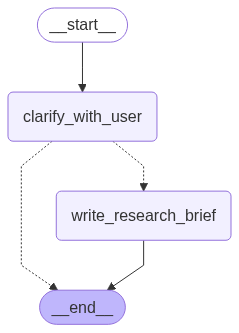

In [8]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [9]:
def format_message_content(message):
    """Convert message content to displayable string"""
    parts = []
    tool_calls_processed = False
    
    # Handle main content
    if isinstance(message.content, str):
        parts.append(message.content)
    elif isinstance(message.content, list):
        # Handle complex content like tool calls (Anthropic format)
        for item in message.content:
            if item.get('type') == 'text':
                parts.append(item['text'])
            elif item.get('type') == 'tool_use':
                parts.append(f"\n🔧 Tool Call: {item['name']}")
                parts.append(f"   Args: {json.dumps(item['input'], indent=2)}")
                parts.append(f"   ID: {item.get('id', 'N/A')}")
                tool_calls_processed = True
    else:
        parts.append(str(message.content))
    
    # Handle tool calls attached to the message (OpenAI format) - only if not already processed
    if not tool_calls_processed and hasattr(message, 'tool_calls') and message.tool_calls:
        for tool_call in message.tool_calls:
            parts.append(f"\n🔧 Tool Call: {tool_call['name']}")
            parts.append(f"   Args: {json.dumps(tool_call['args'], indent=2)}")
            parts.append(f"   ID: {tool_call['id']}")
    
    return "\n".join(parts)


def format_messages(messages):
    """Format and display a list of messages with Rich formatting"""
    for m in messages:
        msg_type = m.__class__.__name__.replace('Message', '')
        content = format_message_content(m)

        if msg_type == 'Human':
            console.print(Panel(content, title="🧑 Human", border_style="blue"))
        elif msg_type == 'Ai':
            console.print(Panel(content, title="🤖 AI", border_style="green"))
        elif msg_type == 'Tool':
            console.print(Panel(content, title="🔧 Tool Output", border_style="yellow"))
        else:
            console.print(Panel(content, title=f"📝 {msg_type}", border_style="white"))


def format_message(messages):
    """Alias for format_messages for backward compatibility"""
    return format_messages(messages)

In [10]:
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "1"}}
result = scope.invoke({"messages": [HumanMessage(content="I want to research the best way to invest in the stock market with recent tariffs.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best way to invest in the stock market with recent tariffs.                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To tailor the research to your needs, could you please clarify:                                                 │
│                                                                                                                 │
│ 1. Which country's or region's stock market are you interested in (e.g., US, EU, China, global)?                │
│ 2. Are there specific recent tariffs or trade disputes you want to focus on?                                    │
│ 3. What is your investment horizon (short-term, long-term, or both)?                                            │
│ 4. Do you want a general overview or a detailed analysis with actionable investment strategies?                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [11]:

result = scope.invoke({"messages": [HumanMessage(content="I am mostly into US markets, IT sectors and Banking, for long term investment.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best way to invest in the stock market with recent tariffs.                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To tailor the research to your needs, could you please clarify:                                                 │
│                                                                                                                 │
│ 1. Which country's or region's stock market are you interested in (e.g., US, EU, China, global)?                │
│ 2. Are there specific recent tariffs or trade disputes you want to focus on?                                    │
│ 3. What is your investment horizon (short-term, long-term, or both)?                                            │
│ 4. Do you want a general overview or a detailed analysis with actionable investment strategies?                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I am mostly into US markets, IT sectors and Banking, for long term investment.                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify which recent tariffs or trade disputes you are referring to in the context of the US IT and   │
│ Banking sectors? Are there particular countries or products involved in these tariffs that you want the         │
│ analysis to focus on?                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [13]:

result = scope.invoke({"messages": [HumanMessage(content="I am more concerned about how comapnies in the US are gonna play with Trump increasing tarrifs and most technology companies do import stuff from other countries like India, China. So You analysis can be broad.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best way to invest in the stock market with recent tariffs.                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To tailor the research to your needs, could you please clarify:                                                 │
│                                                                                                                 │
│ 1. Which country's or region's stock market are you interested in (e.g., US, EU, China, global)?                │
│ 2. Are there specific recent tariffs or trade disputes you want to focus on?                                    │
│ 3. What is your investment horizon (short-term, long-term, or both)?                                            │
│ 4. Do you want a general overview or a detailed analysis with actionable investment strategies?                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I am mostly into US markets, IT sectors and Banking, for long term investment.                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify which recent tariffs or trade disputes you are referring to in the context of the US IT and   │
│ Banking sectors? Are there particular countries or products involved in these tariffs that you want the         │
│ analysis to focus on?                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I am more concerned about how comapnies in the US are gonna play with Trump increasing tarrifs and most         │
│ technology companies do import stuff from other countries like India, China. So You analysis can be broad.      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for the details. You are interested in a broad analysis of long-term investment strategies in the US  │
│ stock market, focusing on the IT and Banking sectors, in the context of recent and potential future tariffs     │
│ under Trump, particularly regarding imports from countries like China and India. I will now begin the research  │
│ process with these parameters in mind.                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [14]:
from rich.markdown import Markdown
Markdown(result["research_brief"])

I want to research the best long-term investment strategies in the US stock market, specifically focusing on the IT
and Banking sectors, in the context of recent and potential future tariffs imposed or proposed by Donald Trump,    
particularly those affecting imports from countries like China and India. My goal is to understand how these       
tariffs may impact the performance and strategies of US-based IT and Banking companies, and how investors can best 
position their portfolios in light of these trade policies. Please consider all relevant factors, such as supply   
chain disruptions, cost structures, sector-specific vulnerabilities, and historical responses to similar tariff    
environments. If there are other important dimensions (e.g., macroeconomic effects, regulatory changes, or global  
market reactions) that should be considered for a comprehensive analysis, please include them as open              
considerations. I have not specified any particular companies, sub-sectors, or investment vehicles, so please treat
these as flexible unless evidence suggests a focus is warranted.